In [19]:
import sys
import os
sys.path.append(os.path.dirname(os.path.realpath("")))

In [20]:
from os.path import join

from gensim.models import KeyedVectors
import fasttext as ft
import pandas as pd
import numpy as np
import umap
import umap.plot
import hdbscan
from sklearn.cluster import DBSCAN

import utilities

pd.set_option('display.max_rows', 500)

In [21]:
lexicon = utilities.get_arabic_lexicon_data("..")

In [22]:
glf_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "glf.vec"))
egy_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "egy.vec"))
irq_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "irq.vec"))
nor_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "nor.vec"))
lev_embedding = KeyedVectors.load_word2vec_format(join("embeddings", "lev.vec"))

In [23]:
def generate_emotion_lexicon(embedding, emotion, min_cluster_size, num_words_to_generate=100, verbose=False, save=False, embedding_name=None):
    if save:
        assert embedding_name is not None, "embedding_name must not be None when trying to save" 
    
    lexicon = utilities.get_arabic_lexicon_data("..")
    def get(embedding, val, default=None):
        try:
            return embedding[val]
        except KeyError:
            return default

    emotions = list(lexicon.keys())
    if verbose:
        print(f"Emotions in lexicon {emotions}")
    assert emotion in lexicon, f"The emotion {emotion} is not in the Lexicon"

    vecs_non_filtered = list(map(lambda wrd: get(glf_embedding, wrd, default=None), lexicon[emotion]))
    if verbose:
        print(f"Number of words considered {sum(1 for vec in vecs_non_filtered if vec is not None)}/{len(vecs_non_filtered)}")
    vecs = list(filter(lambda x: x is not None, vecs_non_filtered))
    centroid = np.mean(vecs, axis=0)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(vecs)

    if verbose:
        print(cluster_labels)
    cluster_to_words = {}
    for focus_cluster in np.unique(cluster_labels):
        clustered_vecs = [vec for cluster, vec in zip(cluster_labels, vecs) if cluster == focus_cluster]
        clustered_centroid = np.median(clustered_vecs, axis=0)
        cluster_to_words[focus_cluster] = list(zip(*glf_embedding.similar_by_vector(clustered_centroid, num_words_to_generate)))[0]

    if verbose:
        mapper = umap.UMAP().fit(vecs)
        umap.plot.points(mapper, labels=cluster_labels)
    df = pd.DataFrame(cluster_to_words)
    style = df.style.applymap(lambda x: "background-color: rgba(20, 20, 20, 1)" if x in lexicon[emotion] else "")
    if save:
        df.to_csv(f"emotion_lexicon/{embedding_name}_{emotion}_minclustersize={min_cluster_size}.csv")
    return style

## Problems

### Problem with using all words in generating similar words
### Solution: cluster the vector representation of words

In [24]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="anger", min_cluster_size=100, num_words_to_generate=500)
df.data.iloc[:20]

,-1
0,فی
1,ضفدع
2,شآء
3,لعنبو
4,ضف
5,ضب
6,رآي
7,ث
8,***
9,قذف


### Problem with centroid idea
### Solution(?): Maybe decrease the min_cluster_size?
![img](https://www.researchgate.net/profile/Fotios-Katsilieris-2/publication/239926467/figure/fig4/AS:669426328301595@1536615082633/An-example-of-the-difference-between-a-convex-and-a-non-convex-region.ppm)


# Notes

### finding the centroid with the mean seems to give worse performance than finding it with the median. Probably since the mean is swayed by outlier vectors 

# Glf

Emotions in lexicon ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Number of words considered 465/1092
[ 7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  7  7 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  7 -1  7 -1 -1 -1 -1 -1  7  7  7 -1 -1 -1 -1  8  7  7 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1  8  8 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  8  8 -1 -1 -1  8  8 -1 -1 -1  8  8 -1 -1  8  8 -1  8  8  8  7
  7  7  1 -1  7 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1 -1  7  7  1  2  2 -1
 -1 -1 -1 -1 -1 -1 -1  7  0  1 -1 -1 -1  0  0  5 -1  5  5  0  5  5  5  5
 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  3 -1  2  1 -1 -1 -1  3 -1  0  5 -1
  1  3  1 -1 -1 -1  3  3 -1 -1  6  6  8 -1  2  2 -1 -1  2  2  1  3  0 -1
 -1 -1  0  5 -1 -1 -1 -1 -1 -1 -1  8 -1  6 -1 -1 -1  6 -1 -1  4  3 -1  6
 -1 -1  4  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1  6 -1 -1  4  3 -1  4 -1
 -1 -1  4  4  4 -1 -1 -1 -1 -1 -1  4  4  4 -1 -1 -1 -1  0 -1  4  0 -1 -1
  6  6  0

,-1,0,1,2,3,4,5,6,7,8
0,ضفدع,كره,حقد,عداء,حسد,حاقد,كراهية,طمع,غضب,غاضب
1,فی,نكره,يحقد,أعداء,وحسد,وحاقد,رفاهية,دمع,تغضب,غامضة
2,شآء,مكره,وحقد,فداء,حسدا,حاسد,الكراهية,يطمع,يخذل,غافل
3,هتلر,تكره,هالحقد,نداء,يحسد,يحقد,داهية,مطمع,يغضب,اﻵن
4,***,أكره,تحقد,اعداء,حاسد,مثقف,والكراهية,شـوفه,ضب,يغضب
5,ث,ثغره,حاقد,داء,فاسد,فی,الرفاهية,غبــت,رآه,غ
6,ضف,لبكره,طائفية,إهداء,حسيبهم,حقد,طائفية,مـع,يأذن,أذى
7,لعنبو,اكره,كفؤ,بأداء,حسبهم,وحقد,واهية,تدمع,طحن,لئن
8,ض,كفره,طائفيه,شهداء,الحسد,الحاقد,همجية,عـن,يخشى,غامض
9,غ,صغره,الحقد,وسعداء,كفؤ,هتلر,الليبرالية,جرحه,يبكي,سيعؤضك


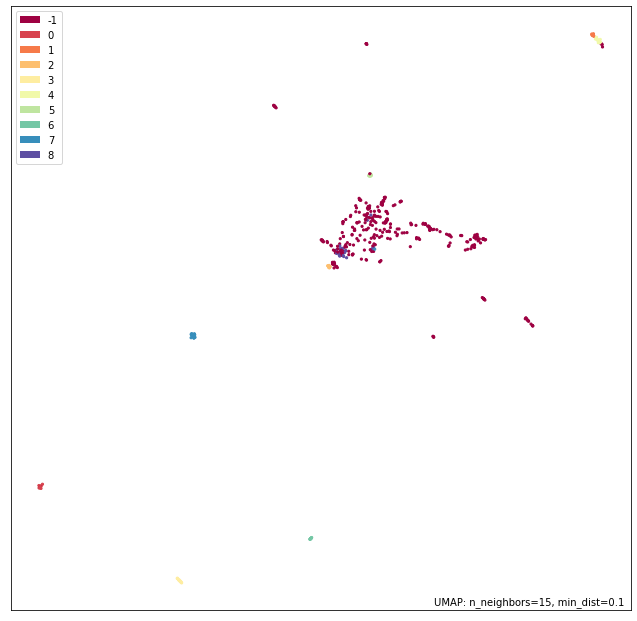

In [37]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="anger", min_cluster_size=8, num_words_to_generate=100, verbose=True)
df

In [38]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="joy", min_cluster_size=15, num_words_to_generate=100)
df

,-1,0,1,2,3,4
0,ضفدع,سعيد,مرح,سعادة,ضفدع,فرح
1,كﻻم,وسعيد,مرحبآ,بسعادة,فی,فرحا
2,ظ,عيد,مرحب,لسعادة,شآء,فرحه
3,شآء,صعيد,مرآة,ياسعادة,***,بفرح
4,***,وعيد,مرصد,وسعادة,ضجيج,مفرح
5,تيقن,السعيد,مرحله,سعاد,تيقن,فرحتك
6,فی,سعيدا,مرهه,السعادة,نذل,تفرح
7,لؤي,أعيد,مرحوم,كعادة,كﻻم,نفرح
8,ض,نعيد,مرحلة,والسعادة,غدآ,أفرح
9,ﻫﻮ,أضحى,مرشد,بالسعادة,ألوآن,افرح


In [39]:
df = generate_emotion_lexicon(embedding=glf_embedding, emotion="disgust", min_cluster_size=3, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5
0,فی,برفض,قذر,سقم,قرف,مقرف,فاسد
1,ث,ورفض,اقذر,سق,مقرف,قرف,فاسق
2,***,اترفض,مستنقع,سخطك,وقرف,جرف,فاسده
3,لعنبو,رفضة,بصاروخ,سقما,هرن,مقرفة,فاسدة
4,ضفدع,انرفض,أقذر,سحائب,خن,مقزز,خائن
5,بصاروخ,ورفضه,غزو,غيثا,قرش,مقوش,حاسد
6,إنحطاط,فرفضت,سلطنه,ياأرحم,جرف,مجبوس,تدمير
7,قذف,رفضه,ديمقراطيه,تطمئن,اشبع,خن,إنحطاط
8,هتلر,سترفض,الليبراليه,بعفوك,يطرش,مقرود,فی
9,شآء,ورفضت,تذبح,صـل,ومطنوخ,هرن,عجائب


# Egy

In [40]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="joy", min_cluster_size=13, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5
0,ضفدع,سعيد,مرح,سعادة,فرح,بهجة,مفرح
1,***,وسعيد,مرحبآ,بسعادة,فرحا,فی,بفرح
2,شآء,عيد,مرحب,لسعادة,فرحه,بهآ,نفرح
3,كﻻم,صعيد,مرآة,ياسعادة,بفرح,ضجيج,تفرح
4,ظ,وعيد,مرصد,وسعادة,مفرح,ﻫﻮ,فرح
5,فی,السعيد,مرحله,سعاد,فرحتك,ألوآن,ونفرح
6,تيقن,سعيدا,مرهه,السعادة,تفرح,اﻵن,وأفرح
7,ض,أعيد,مرحوم,كعادة,نفرح,ضفدع,أفرح
8,هتلر,نعيد,مرحلة,والسعادة,أفرح,شآء,يفرح
9,لؤي,أضحى,مرشد,بالسعادة,افرح,مذاق,افرح


In [41]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="fear", min_cluster_size=7, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8
0,رآي,قلق,جبان,خوف,مرعب,رعب,فزع,مخيف,متردد,رهيب
1,تيقن,وقلق,ذيبان,وخوف,رعب,كعب,صـل,سخيف,مترددة,صهيب
2,فی,يقلق,صوحان,تخوف,كعب,ﻻعب,آلبآل,مخزي,متردده,عجيييب
3,ضفدع,تقلق,جبران,يخوف,ﻻعب,مرعب,لبيــــه,مخيم,تردد,مهيب
4,جشع,قلقي,رهان,خوفي,مرعبه,نلعب,وآنس,مخيس,تتردد,ذيب
5,غ,للقلق,مدان,خوفا,مرهه,بيلعب,هف,وخفيف,يتردد,كئيب
6,تهجم,لاتقلق,اوطان,للخوف,نلعب,بملعب,وآل,مخي,ردد,اييب
7,نضج,تخلق,قرفان,الخوف,فشخ,لعب,فزد,نزيف,متعذر,سيب
8,هتلر,والقلق,خربان,اظمى,بوسكيتس,بتلعب,كلـــہ,مزيف,ترددت,تييب
9,فشخ,يخلق,سرطان,متخوف,فخم,هرن,سحائب,مخ,متضايقة,تأنيب


In [42]:
df = generate_emotion_lexicon(embedding=egy_embedding, emotion="anger", min_cluster_size=7, num_words_to_generate=100)
df

,-1,0,1,2,3,4,5,6,7,8,9,10
0,ضفدع,غيرة,كره,حقد,عداء,حسد,حاقد,كراهية,طمع,خبث,غضب,غاضب
1,فی,وصغيرة,نكره,يحقد,أعداء,وحسد,وحاقد,رفاهية,دمع,خبيث,تغضب,غامضة
2,شآء,الغيرة,مكره,وحقد,فداء,حسدا,حاسد,الكراهية,يطمع,خبص,يخذل,غافل
3,هتلر,متغيرة,تكره,هالحقد,نداء,يحسد,يحقد,داهية,مطمع,صآفي,يغضب,اﻵن
4,***,فقيرة,أكره,تحقد,اعداء,حاسد,مثقف,والكراهية,شـوفه,خب,ضب,يغضب
5,ث,صغيرة,ثغره,حاقد,داء,فاسد,فی,الرفاهية,غبــت,شآء,رآه,غ
6,ضف,حيرة,لبكره,طائفية,إهداء,حسيبهم,حقد,طائفية,مـع,لعنبو,يأذن,أذى
7,غ,خطيرة,اكره,كفؤ,بأداء,حسبهم,وحقد,واهية,تدمع,ضفدع,طحن,لئن
8,فشخ,ديرة,كفره,طائفيه,شهداء,الحسد,الحاقد,همجية,عـن,تغانم,يخشى,غامض
9,ض,صايرة,صغره,الحقد,وسعداء,كفؤ,هتلر,الليبرالية,جرحه,خبيثة,يبكي,سيعؤضك


# Lev

In [43]:
df = generate_emotion_lexicon(embedding=lev_embedding, emotion="disgust", min_cluster_size=7, num_words_to_generate=100)
df

,-1,0,1
0,فی,قرف,سقم
1,بصاروخ,مقرف,سق
2,إنحطاط,خن,سخطك
3,ث,هرن,سقما
4,فاسد,جرف,سحائب
5,خائن,مطنوخ,غيثا
6,قذر,ومطنوخ,ياأرحم
7,قذف,تهايط,تطمئن
8,غ,هتلر,بعفوك
9,ضفدع,هدب,صـل


# NOR

In [44]:
df = generate_emotion_lexicon(embedding=nor_embedding, emotion="sadness", min_cluster_size=30, num_words_to_generate=100)
df

,-1,0,1,2
0,ضفدع,حزين,بحزن,حزن
1,شآء,وحزين,محزن,وحزن
2,فی,حزينه,وحزن,بحزن
3,مـع,الحزين,حزن,أحزن
4,نذل,ازين,احزن,حزنت
5,شخـص,تزين,نحزن,تحزن
6,ضف,مكبرين,ومحزن,يحزن
7,رآح,حنين,أحزن,نحزن
8,ֆء,يزين,يحزن,حزنك
9,ض,شين,تحزن,حزنه


In [45]:
df = generate_emotion_lexicon(embedding=nor_embedding, emotion="anger", min_cluster_size=15, num_words_to_generate=100)
df

,-1,0,1,2
0,فی,حسد,غضب,غاضب
1,ضفدع,وحسد,تغضب,غامضة
2,هتلر,حسدا,يخذل,غافل
3,شآء,يحسد,يغضب,اﻵن
4,لعنبو,حاسد,ضب,يغضب
5,ضف,فاسد,رآه,غ
6,ث,حسيبهم,يأذن,أذى
7,***,حسبهم,طحن,لئن
8,ض,الحسد,يخشى,غامض
9,نذل,كفؤ,يبكي,سيعؤضك
